In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as stats

<br>

# Motivation

---

Many machine learning algorithms take the the assumption that the data points are independent and identically distributed.

This is a reasonable assumption if we try to classify images that were reassembled by crawling the internet. But some sequence of data points are not independent are in fact highly correlated:

* the successive images in a movies (should you see a cat, seeing a cat at the next frame is very likely)
* the sequence of positions in a game such as Chess (the board will overall be similar)
* the words in a sentence in NLP (due to the structure of the sentence and the context)
* the prices of a financial product over time (made of tendencies + noise)

Models that are suited for independent sample data points will stuggle here. Decoding a sentence word by word, not taping into the extraordinary sources of correlations between words, will likely lead to bad performances.

We can sometimes adapt the situation. For instance in Deep Reinforcement Learning, a Q-network might be given mini-batch of randomly sampled board situation for a game like Go (so that the i.i.d. assumption is approximated as best as possible). But in general, this will not be possible.

We will thefore now look at models that work with the assumption that data points have some relationship between the element $x_n$ and the elements $x_1 \dots x_{n-1}$ that preceeded it.

<br>

# Markov Processes
---

Assuming that a data point $x_n$ depends on the values $x_1 \dots x_n$ that preceeds it leads to two problems. The first one is that the distribution is of a different shape at each new points (more and more parameters), the second one is that the distribution complexity grows exponentially. Markov processes are one way to solve this problem.

<br>

### Definition

The **markov assumption** says that each data point is **dependent only a fixed number of previous points** and not on the points that preceeded it. We call such a random process an order-K markov process. 

&emsp; $p(x_n | x_{n-1} \dots x_1) = p(x_n | x_{n-1} \dots x_{n-k})$

A markov process is a **stationary process** if the probability $p(x_n|x_{n-1} \dots x_{n-k})$ remains constant over time (it only depends on the values and not on the specific $n$). This occurs when the data generative process that creates the data, the distribution of the data, stays the same over time.

An order-1 homogeneous markov process is usually what we talk about when mentioning markov processes: the point $x_n$ only depend on the value of the previous point $x_{n-1}$ and stays the same over time. For discrete finite random variables, such processes can be encoded by a **transition matrix**.

<br>

### Stationary distribution

If $\Omega$ is the universe of values the random variables $x_i$ can take, a **stationary distribution** is a probability distribution $p$ over $\Omega$, such that this distribution remains the same between $x_n$ and $x_{n+1}$ (and consequently forever after that).

Under some assumptions (ergodicity), a markov process will have one and only one stationary distribution, and will converge toward that distribution. The convergence is called the **mixing time** and will be shorter when the uncertainty is higher.

For an order-1 homogeneous markov process on a discrete finite random variable, encoded by the transition matrix $M$, a stationary distribution is therefore a vector $p$ that describes a distribution ($\sum_i p_i = 1$ and $p_i \ge 0$) such that $M p = p$, or in other words, an **eigenvector** of $M$ with eigenvalue 1.

We can also compute the stationary distribution by **raising the transition matrix to increasing powers**. It will converge to a matrix such that each column represents the stationary distribution.

<br>

### Example

An employee is in either room A or room B. When in room A, the employee has a 90% to stay in that room (for work) and 10% to change room (after a break). For room B, because it is less cosy, the percentages are 80% and 20%.

We therefore look for the eigenvectors of the transition matrix:

&emsp; $P = \begin{pmatrix} 0.9 & 0.2 \\ 0.1 & 0.8 \end{pmatrix}$
&emsp; where the column match the destinations of $\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ and $\begin{pmatrix} 0 \\ 1 \end{pmatrix}$ respectively

Only the eigenvectors that are positive and correspond to the eigenvalue 1 should be kept:

In [2]:
transition_matrix = np.array([
    [0.9, 0.2],
    [0.1, 0.8]])

eigenvalues, eigenvectors = np.linalg.eig(transition_matrix)
p = eigenvectors.T[0]
p /= np.sum(p)
print("Stationary distribution (eigen vector):", p)

m_100 = np.linalg.matrix_power(transition_matrix, 100)
print("Stationary distribution (matrix power):", m_100[:,0].T)

Stationary distribution (eigen vector): [0.66666667 0.33333333]
Stationary distribution (matrix power): [0.66666667 0.33333333]


<br>

# State Space Models
---

The choice of the order in a Markov Process is a difficult trade-off. A big order will make the model more powerful but also more expensive. Even for big orders, the inability to depend on the whole past sequence remains a limitation. State space models offer an alternative way to **depend on the whole past observation sequence, while remaining tractable**.

<br>

### Definition

A state space model is a model based on **latent variables** (unobserved variables) $z_1 \dots z_n$ which follow a Markov Process. There is one latent variable by data point that we observe. The observations $x_1 \dots x_n$ themselves do not form a Markov Process themselves, but are instead generated using an **emission process** $p(x_i|z_i)$.

**Hidden Markov Models** are state space models in which the **latent variables are discrete random variables**. The emision distribution might not be a discrete distribution, but can be a gaussian, parameterized on the latent variable for instance.

**Linear Dynamical System** are state space models in which the **latent variables are continuous random variables**, for instance vectors of reals. Because it is easier when $p(x_n|x_{n-1})$ keeps the same shape for each $n$, this conditional distribution is often chosen to be a distribution of the exponential family, and in particular a gaussian.

As for all directed models (Bayesian Network), we can use ancestral sampling to generate sample inputs. For inference of the latent variables, we have to turn to forward backward algorithms, or Vitervi algorithm.

<br>

### Typical Tasks

We have a sequence of $N$ observations $x_1 \dots x_N$ with $N$ unobserved latent variables $z_1 \dots z_N$ associated to each state. The typical tasks associated with Hidden Markov Models are:

* **Filtering**: find the value of the last hidden state $p(z_N| x_1 \dots x_N)$ from past observations
* **Prediction**: find the value of the next observation $p(x_{N+1}|x_1 \dots x_N)$ from past observations
* **Smoothing**: find the value of an arbitrary hidden state: $p(z_n | x_1 \dots x_N)$ from past and future observations
* **Most likely explanation**: find the sequence of hidden state $z_1 \dots z_N$ that best explains $x_1 \dots x_N$

Filtering a special case of smoothing (in which the state of interest is the last state), and prediction follows from filtering:

&emsp; $p(x_{N+1}|x_1 \dots x_N) = p(x_{N+1}|z_{N+1}) \, p(z_{N+1}|z_N) \, p(z_N|x_1 \dots x_N)$

But **smoothing** and **most likely explanation** are not the same thing: it is not equivalent to maximize each $z_n$ individually to maximize the joint distribution $p(z_1 \dots z_N|x_1 \dots x_N)$. There are therefore **two main tasks**.

<br>

### Smoothing: Forward-Backward algorithm

The algorithm to deduce the hidden variable is known as **forward-backward** algorithm and use dynamic programming to deduce the $N$ latent variables in $O(N K^2)$ where $K$ is the number of states of $z$:

&emsp; $\displaystyle p(z_n|X) = \frac{p(X|z_n)p(z_n)}{p(X)} = \frac{\alpha(z_n) \beta(z_n)}{p(X)}$
&emsp; with:
&emsp; $\alpha(z_n) = p(x_1 \dots x_n, z_n)$
&emsp; $\beta(z_n) = p(x_{n+1} \dots x_N | z_n)$

&emsp; $\displaystyle \alpha(z_{n}) = p(x_n|z_n) \sum_{z_{n-1}} \alpha(z_{n-1}) p(z_n|z_{n-1})$
&emsp; initialized with
&emsp; $\forall z_1, \; \alpha(z_{1}) = p(x_1|z_1) p(z_1)$

&emsp; $\displaystyle \beta(z_{n}) = \sum_{z_{n+1}} p(x_{n+1}|z_{n+1}) \beta(z_{n+1}) p(z_{n+1}|z_n)$
&emsp; initialized with
&emsp; $\forall z_N, \; \beta(z_{N}) = 1$

Using this the $\alpha$ left to right pass, we can easily deduce the probability of the last state $z_N$. Using the $\beta$ right to left pass, we can easily deduce the probability of any $z_n$ in the middle (for instance, to find a missing value in the middle).

Please note that **this requires to know the probability distributions** $p(z_n|z_{n-1})$ and $p(x_n|z_n)$. This makes this inference mechanism useful for the **E-step of the EM algorithm** (to deduce the $z_n$ associated with the $x_n$ to afterward maximize expectation of the log joint probability distribution).

<br>

### Proof of forward-backward algorithm

We can use the *d-separation* criteria (blocking path in a Bayesian network) to prove that:

&emsp; $\displaystyle p(z_n|X) = \frac{p(X|z_n)p(z_n)}{p(X)} = \frac{p(x_1 \dots x_n| z_n) p(x_{n+1} \dots x_N| z_n) p(z_n)}{p(X)}$

We can then use the same *d-separation* criteria to demonstrate the recursion for $\alpha$:

&emsp; $\alpha(z_n) = p(x_1 \dots x_n| z_n) p(z_n)$

&emsp; $\alpha(z_n) = p(x_n|z_n) p(x_1 \dots x_{n-1}|z_n) p(z_n)$

&emsp; $\alpha(z_n) = p(x_n|z_n) p(x_1 \dots x_{n-1},z_n)$

&emsp; $\alpha(z_n) = p(x_n|z_n) \sum_{z_{n-1}} p(x_1 \dots x_{n-1},z_n| z_{n-1}) p(z_{n-1})$

&emsp; $\alpha(z_n) = p(x_n|z_n) \sum_{z_{n-1}} p(z_n|z_{n-1}) p(x_1 \dots x_{n-1}| z_{n-1}) p(z_{n-1})$

&emsp; $\alpha(z_n) = p(x_n|z_n) \sum_{z_{n-1}} p(z_n|z_{n-1}) \alpha(z_{n-1})$

We can do similarly for $\beta$:

&emsp; $\beta(z_n) = p(x_{n+1} \dots x_N | z_n)$

&emsp; $\beta(z_n) = \sum_{z_{n+1}} p(x_{n+1} \dots x_N | z_n, z_{n+1}) \, p(z_{n+1}|z_n)$

&emsp; $\beta(z_n) = \sum_{z_{n+1}} p(x_{n+1}|z_{n+1}) \, p(x_{n+2} \dots x_N | z_{n+1}) \, p(z_{n+1}|z_n)$

<br>

### Most Likely Explanation: Viterbi algorithm

The algorithm used to find the most likely explanation $z_1 \dots z_N$ to the observation $x_1 \dots x_N$ is closely related to the $\alpha$ forward pass that we used for smoothing, but uses the *max* operation instead of a summation.

&emsp; $\displaystyle v(z_{n}) = p(x_n|z_n) \; \underset{z_{n-1}}{\operatorname{max}} \big(v(z_{n-1}) p(z_n|z_{n-1}) \big)$
&emsp; initialized with
&emsp; $\forall z_1, \; v(z_{1}) = p(x_1|z_1) p(z_1)$

Each time we select a *max* value for $z_n$, we also keep record of the $z_{n-1}$ value that lead to this maximum. At the end, we pick the maximium value for $z_N$ and then use the back-pointers to recover the path that lead to this most likely explanation. 

<br>

### Proof of the Viterbi algorithm

As for the forward-backward algorithm, we use the *d-separation* criteria and Bayes' theorem to show the recursion:

&emsp; $\displaystyle v(z_N) = \underset{z_1 \dots z_{N-1}}{\operatorname{max}} p(z_1 \dots z_N | x_1 \dots x_N)$

&emsp; $\displaystyle v(z_N) = \underset{z_1 \dots z_{N-1}}{\operatorname{max}} p(z_1 \dots z_{N-1} | x_1 \dots x_N, z_N) \, p(z_N | x_1 \dots x_N)$
&emsp; (Product rule)

&emsp; $\displaystyle v(z_N) \propto \underset{z_1 \dots z_{N-1}}{\operatorname{max}} p(z_1 \dots z_{N-1} | x_1 \dots x_N, z_N) \, p(x_1 \dots x_N | z_N) \, p(z_N)$
&emsp; (Bayes rule)

&emsp; $\displaystyle v(z_N) \propto \underset{z_1 \dots z_{N-1}}{\operatorname{max}} p(z_1 \dots z_{N-1} | x_1 \dots x_{N-1}, z_N) \, p(x_1 \dots x_{N-1} | z_N) \, p(x_N | z_N) \, p(z_N)$
&emsp; (d-separation)

&emsp; $\displaystyle v(z_N) \propto \underset{z_1 \dots z_{N-1}}{\operatorname{max}} p(z_1 \dots z_{N-1} | x_1 \dots x_{N-1}, z_N) \, p(z_N | x_1 \dots x_{N-1}) \, p(x_N | z_N)$
&emsp; (Bayes rule)

&emsp; $\displaystyle v(z_N) \propto \underset{z_1 \dots z_{N-1}}{\operatorname{max}} p(z_1 \dots z_{N-1}, z_N | x_1 \dots x_{N-1}) \, p(x_N | z_N)$
&emsp; (Product rule)

&emsp; $\displaystyle v(z_N) \propto \underset{z_1 \dots z_{N-1}}{\operatorname{max}} p(z_1 \dots z_{N-1} | x_1 \dots x_{N-1}) \, p(z_N|z_{N-1}) \, p(x_N | z_N)$
&emsp; (d-separation)

&emsp; $\displaystyle v(z_N) \propto \underset{z_{N-1}}{\operatorname{max}} p(x_N | z_N) \, p(z_N|z_{N-1}) \, \underset{z_1 \dots z_{N-1}}{\operatorname{max}} p(z_1 \dots z_{N-2} | x_1 \dots x_{N-1})$
&emsp; (splitting max)

&emsp; $\displaystyle v(z_N) \propto p(x_N | z_N) \, \underset{z_{N-1}}{\operatorname{max}} p(z_N|z_{N-1}) \, v(z_{N-1})$
&emsp; (recursion)

<br>

### Example

We have latent variable that is a bit, that flips with probability 20%. The sequence starts at (0.5, 0.5). We add white noise to the message, and we want to decode the message:

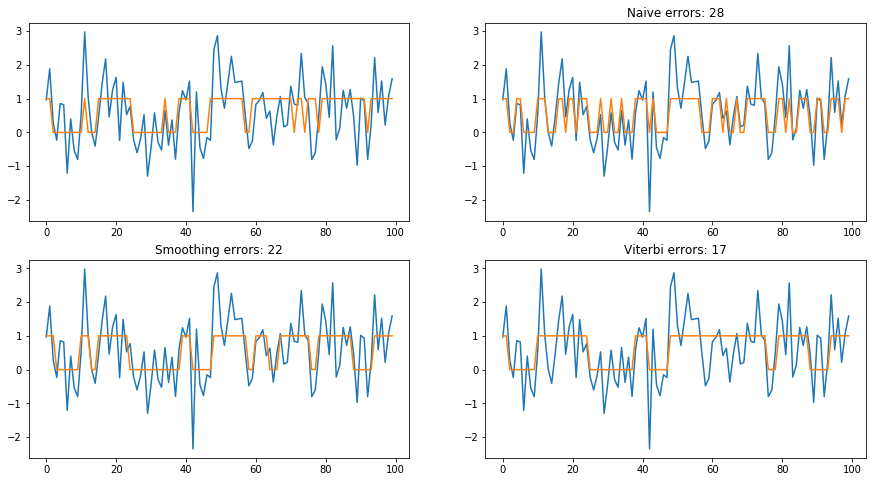

In [4]:
noise_scale=0.8
train_zs = np.zeros(shape=100)
train_zs[0] = np.random.choice([0, 1])
train_zs[1:] = np.random.choice([0, 1], p=[0.8, 0.2], size=len(train_zs) - 1)
train_zs = np.cumsum(train_zs) % 2
train_xs = train_zs + np.random.normal(loc=0., scale=noise_scale, size=train_zs.shape)


def smoothing_on_all(train_xs):
    """
    Computes the probability of each z_n, then returns the maximum.
    This is BAD of most likely explanation: the joint probability is not optimal.
    """
    alphas = np.full(shape=(len(train_zs), 2), fill_value=0.5)
    for i in range(1, len(alphas)):
        for d in range(2):
            p_x_z = stats.norm(loc=d, scale=noise_scale).pdf(train_xs[i])
            alphas[i][d] = p_x_z * (alphas[i-1][d] * 0.8 + alphas[i-1][1-d] * 0.2)

    betas = np.full(shape=(len(train_zs), 2), fill_value=1.0)
    for i in reversed(range(0, len(betas)-1)):
        for d in range(2):
            betas[i][d] = betas[i+1][d] * 0.8 * stats.norm(loc=d, scale=noise_scale).pdf(train_xs[i+1])
            betas[i][d] += betas[i+1][1-d] * 0.2 * stats.norm(loc=1-d, scale=noise_scale).pdf(train_xs[i+1])

    p_zn = alphas * betas
    return np.argmax(p_zn, axis=-1)  # This is the BAD PART

def viterbi_decoding(train_xs):
    """
    MAX-PRODUCT algorithm: also called the VITERBI algorithm
    - maximize the probability of z_N at the end
    - keep trace of your best decision so far
    """    
    alphas = np.full(shape=(len(train_xs), 2), fill_value=0.5)
    previous = np.full(shape=(len(train_xs), 2), fill_value=0)
    for i in range(1, len(alphas)):
        for d in range(2):
            p_x_z = stats.norm(loc=d, scale=noise_scale).pdf(train_xs[i])
            prev_same = alphas[i-1][d] * 0.8
            prev_other = alphas[i-1][1-d] * 0.2
            previous[i][d] = d if prev_same > prev_other else 1-d
            alphas[i][d] = p_x_z * max(prev_same, prev_other)
    
    decoded = np.zeros(shape=len(train_xs), dtype=np.int32)
    decoded[-1] = 0 if alphas[-1][0] > alphas[-1][1] else 1
    for i in reversed(range(len(decoded)-1)):
        decoded[i] = previous[i+1][decoded[i+1]]
    return decoded


def naive_decoding(train_xs):
    p_x_z = np.full(shape=(len(train_zs), 2), fill_value=0.5)
    for i in range(len(p_x_z)):
        for d in range(2):
            p_x_z[i][d] = stats.norm(loc=d, scale=noise_scale).pdf(train_xs[i])
    return np.argmax(p_x_z, axis=-1)


smoothed = smoothing_on_all(train_xs)
viterbi_decoded = viterbi_decoding(train_xs)
naive_decoded = naive_decoding(train_xs)

_, ax = plt.subplots(figsize=(15,8), nrows=2, ncols=2)
ax[0][0].plot(train_xs)
ax[0][0].plot(train_zs)
ax[0][1].plot(train_xs)
ax[0][1].plot(naive_decoded)
ax[0][1].set_title("Naive errors: " + str(np.sum(naive_decoded != train_zs)))
ax[1][0].plot(train_xs)
ax[1][0].plot(smoothed)
ax[1][0].set_title("Smoothing errors: " + str(np.sum(smoothed != train_zs)))
ax[1][1].plot(train_xs)
ax[1][1].plot(viterbi_decoded)
ax[1][1].set_title("Viterbi errors: " + str(np.sum(viterbi_decoded != train_zs)))
plt.show()

<br>

### Link with Bi-LSTM

**todo**

In [ ]:
# TODO - do the training of a Bi-LSTM

<br>

# Markov Decision Processes: MDP and POMDP
---

Markov Decision Processes (MDP) and Partially Observable Markov Decision Processes, are generalization of Markov Processes and State Space Models (HMM and LDS) for situation when an agent can interact with its environment and modify the state of the world with actions whose effects are probabilistic.

<br>

### Definition

A Partially Observable Markov Decision Process is composed of:

* **states** $s_n$ of the world, which are latent variables
* **observations** $o_n$ from the world, generated from an emission probability $p(o_n|s_n)$
* **actions** $a_n$ that our agent can perform at each state
* **state transitions** which depends on the last state and last action only $p(s_{n+1}|s_n, a_n)$
* **rewards** $r_i$ associated to a transitions subject to the probability $p(r_n, s_{n+1}|s_n, a_n)$

The Bayesian Network that represent the dependency and independence is:

&emsp; $\begin{align} & s_1 \rightarrow o_1 \\ & \downarrow \\ a_1 \rightarrow & s_2 \rightarrow o_2 \\ & \downarrow \\ a_2 \rightarrow & s_3 \rightarrow o_3 \end{align}$

The **policy** is the strategy followed by the agent to **maximize the expected reward over time**. The policy is responsible for the selection of the action $a_i$ at step $i$, that is the action to select based on the past observations $o_1 \dots o_i$ and actions $a_1 \dots a_{i-1}$, or equivalently based on the belief of the state $s_i$.

<br>

### Why Markov?

The transition distribution $p(s_{n+1}|s_n, a_n)$ represents the **model of the world** (how does the world react based on actions). The policy $p(a_n|s_n)$ represents our agent and how it selects its actions. We can combine both in a joint distribution:

&emsp; $p(a_{n+1}|s_{n+1}) \, p(s_{n+1}|s_n, a_n) = p(a_{n+1},s_{n+1}|s_n, a_n)$

This forms a Markov Chain of pairs of state and actions.

<br>

### Maximizing reward

The goal of the policy is to maximize with respect to the the policy the reward over time, the **state value** $\mathbb{V}[s_n]$, the total reward from state $s_n$.

&emsp; $\displaystyle \mathbb{V}[s_n] = \sum_{a_n} p(a_n|s_n) \sum_{s_{n+1}} p(r_n, s_{n+1}|s_n, a_n) \, \big( r_n + \mathbb{V}[s_{n+1}] \big)$

Alternatively, we can maximize the **action-value** $\mathbb{Q}[s_n, a_n]$, the total reword from state $s_n$ if we perform the action $a_n$:

&emsp; $\displaystyle \mathbb{Q}[s_n, a_n] = \sum_{s_{n+1}} p(r_n, s_{n+1}|s_n, a_n) \, \big( r_n + \sum_{a_{n+1}} p(a_{n+1}|s_{n+1}) \, \mathbb{Q}[s_{n+1}] \big)$

The action value and state value are linked together:

&emsp; $\displaystyle \mathbb{V}[s_n] = \sum_{a_n} p(a_n|s_n) \, \mathbb{Q}[s_n, a_n] = \mathbb{E}_{a \sim p(a)}[\mathbb{Q}[s_n, a_n]]$

&emsp; $\displaystyle \mathbb{Q}[s_n, a_n] = \sum_{s_{n+1}} p(r_n, s_{n+1}|s_n, a_n) \big( r_n + \mathbb{V}[s_{n+1}] \big) = \mathbb{E}_{r,s \sim p(s,a)}[r_n + \mathbb{V}[s_{n+1}]]$

Maximizing one with respect to the policy is equivalent in maximizing the other. In general though, the action value is easier to optimize in Reinforcement Learning because we do not have access to the probability distribution $p(r_n, s_{n+1}|s_n, a_n)$: the trick is to select an action and interact with the environment to get the reward and the next state. We use these samples to estimate the true expectation: this is the intuition behind algorithms such as SARSA and Q-Learning.